In [ ]:
import tensorflow as tf

from tensorflow.keras import Sequential, models, layers # type: ignore
from tensorflow.keras.applications import ResNet50, ResNet101,VGG16,VGG19,DenseNet201,DenseNet121,DenseNet169,ResNet152 # type: ignore
from tensorflow.keras.applications import ResNet152,ResNet50V2,ResNet101V2,Xception, InceptionV3, InceptionResNetV2, MobileNet # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load('/content/drive/MyDrive/datasetWithoutCLAHE_TrainAndTest.npz')

train_images = data['train_images']
train_labels = data['train_labels']
# val_images = data['val_images']
# val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

print("Data loaded successfully!")


Data loaded successfully!


In [ ]:
 # Function to resize images to 224x224
def resize_image(image):
    image = tf.image.resize(image, [224, 224]) # default input size for ResNet50
    return image

# Function to normalize the image
def normalize_images(image):
    # Assuming the images are already resized, only normalize them
    # Cast the image to float32 before normalization
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1] range
    return image

# Function to augment the image
def augment_image(image):
    # Randomly flip the image horizontally and vertically
    # Flip with a 50% probability horizontally

    image = tf.image.flip_left_right(image)

    # Flip with a 50% probability vertically

    image = tf.image.flip_up_down(image)

    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Randomly adjust brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Randomly adjust contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Randomly zoom in
    image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
    image = tf.image.random_crop(image, size=[256, 256, 3])

    # Clip the image to ensure values are in the range [0, 1]
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    return image

# Combined function that loads and preprocesses the image
def load_and_preprocess_image(image, label, data_augmentation=True):

    # Normalize and resize the image
    image = normalize_images(image)

    # Apply data augmentation if specified
    if data_augmentation:
        image = augment_image(image)
        #print(f"After data augmentation: {image.shape,image.dtype}")

    # resize the image
    image = resize_image(image)

    return image, label


    # create TensorFlow datasets for each split
# When loading datasets, pass the data_augmentation flag True or False to apply or skip augmentations:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_images , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)
# the augmentations will be applied automatically every time you fetch an image from the train_dataset while data_augmentation=True
# During the training process, each time the model accesses train_dataset, it retrieves the images along with their augmentations.

# val_dataset = tf.data.Dataset.from_tensor_slices( (val_images , val_labels) )
# val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_images , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)



#prepare your datasets for model training and evaluation

batch_size=32  # Specify your desired batch size here
classes=4

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=batch_size*100)  # Shuffle with buffer size

# val_dataset = val_dataset.batch(batch_size)
# val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Load ResNet50 with pre-trained weights, exclude the top layers
base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze the base model to prevent retraining
base_model.trainable = False

In [ ]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())

model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Dense(classes, activation='softmax'))





In [ ]:
# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity)
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MobileNet/Ws/epoch_{epoch:02d}.weights.h5',  # Save file with epoch number
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

# Add callbacks to the fit method
callbacks = [early_stopping, model_checkpoint]


In [ ]:
input_shape = (224, 224, 3)  # Modify as per your model's input dimensions
model.build(input_shape=(None, *input_shape))
# Assuming you have defined your model architecture as `model`
try:
    model.load_weights('/content/drive/MyDrive/MobileNet/Ws/epoch_31.weights.h5')
except ValueError as e:
    print(f"Error loading weights: {e}")


In [ ]:
from tensorflow.keras.optimizers import Adam # type: ignore

optimizer = Adam(learning_rate=0.00001)  # Try a lower value like 0.00001 or higher like 0.001

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Continue training for the remaining epochs
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    #initial_epoch=1,  # Set this to the epoch number you finished on
    epochs=25,  # Continue for the total desired epochs
    callbacks=[model_checkpoint, early_stopping]
)



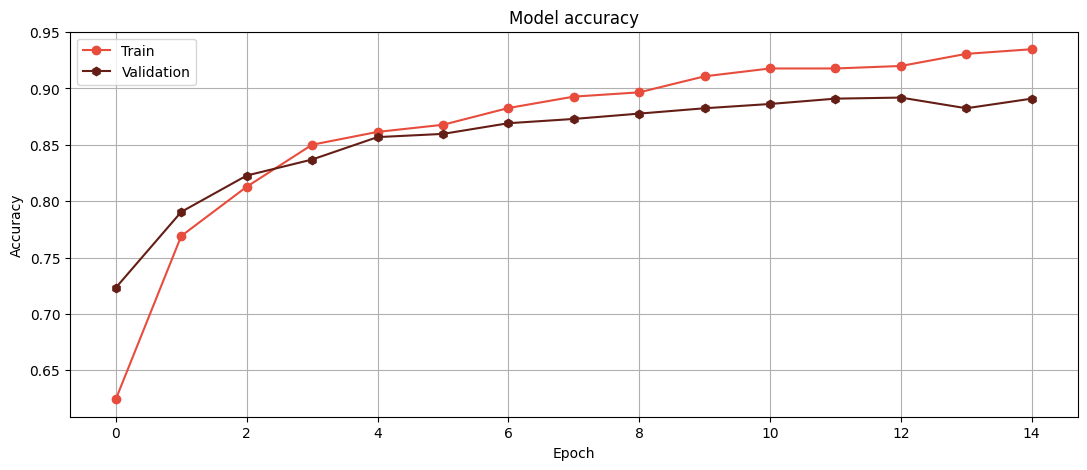

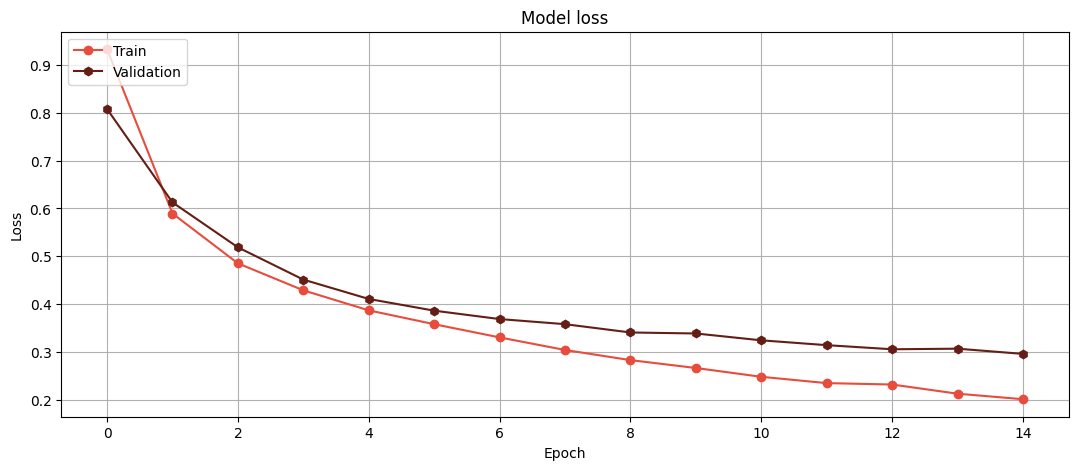

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
#plt.savefig('C:/Users/PC_I/OneDrive/Desktop/accuracy_plot.png')  # Save the accuracy plot as a PNG file
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'], color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
#plt.savefig('C:/Users/PC_I/OneDrive/Desktop/loss_plot.png')  # Save the loss plot as a PNG file
plt.show()


In [ ]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Validation Accuracy: {val_accuracy}")


In [ ]:
print(f"accuracy loss: {train_loss}")
print(f"Validation loss: {val_loss}")

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Load your saved model (e.g., model from the last epoch)
# try:
#     model.load_weights('C:/Users/PC_I/OneDrive/Desktop/EDC/model_epoch_78.weights.h5')
# except ValueError as e:
#     print(f"Error loading weights: {e}")

# Step 2: Make predictions on the validation dataset
y_true = []
y_pred = []

# Iterate through the validation dataset and collect predictions and true labels
for images, labels in test_dataset:  # Assuming val_dataset is already batched
    predictions = model.predict(images)

    # Append the true labels directly if they are integer-encoded
    y_true.extend(labels.numpy())  # Convert TensorFlow tensor to numpy array

    # Append the predicted labels (taking the argmax of the predictions)
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Step 3: Define class names
class_names = ['Cataract', 'Glaucoma', 'Normal', 'DR']  # Adjust based on your classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the class names above the confusion matrix
print(f"Class Names: {', '.join(class_names)}\n")

# Print confusion matrix with class labels
print("Confusion Matrix:\n", conf_matrix)

# Classification report (includes precision, recall, f1-score for each class)
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the class names above the classification report
print(f"\nClassification Report for Classes: {', '.join(class_names)}")
print("\n", report)

In [ ]:
# Step 4: Calculate per-class accuracy from the confusion matrix
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for idx, accuracy in enumerate(per_class_accuracy):
    print(f"Accuracy for class {class_names[idx]}: {accuracy:.2f}")
